Using Device: mps

Loading YOLO model...
Classes: {0: 'Player team left (0)', 1: 'Player team right (1)', 2: 'Goalkeeper team left (2)', 3: 'Goalkeeper team right (3)', 4: 'Ball (4)', 5: 'Main referee (5)', 6: 'Side referee (6)', 7: 'Staff members (7)'}
Total classes: 44
Best jersey model loaded successfully.

STEP 1: Loading Image


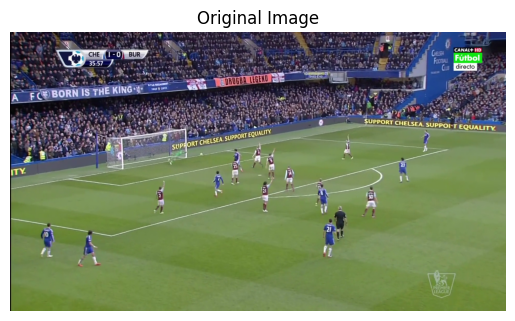


STEP 2: Running YOLO Detection

0: 384x640 12 Player team left (0)s, 14 Player team right (1)s, 65.8ms
Speed: 11.3ms preprocess, 65.8ms inference, 5.2ms postprocess per image at shape (1, 3, 384, 640)
Total Detections: 26

Detection 1
Class: Player team right (1)
BBox: (259, 765, 350, 910)


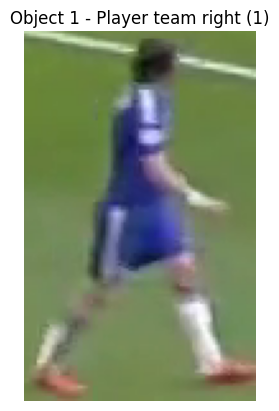

Predicted Jersey: 30
Confidence: 34.23 %

Detection 2
Class: Player team right (1)
BBox: (783, 534, 828, 637)


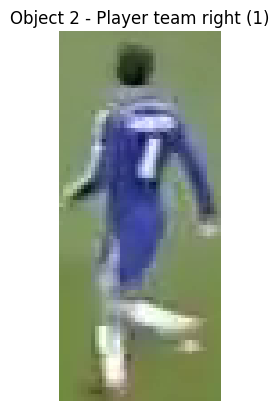

Predicted Jersey: 6
Confidence: 38.9 %

Detection 3
Class: Player team left (0)
BBox: (260, 766, 349, 912)


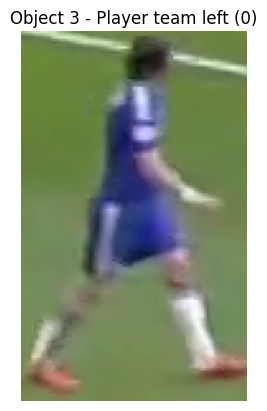

Predicted Jersey: 30
Confidence: 18.35 %

Detection 4
Class: Player team right (1)
BBox: (970, 574, 1007, 699)


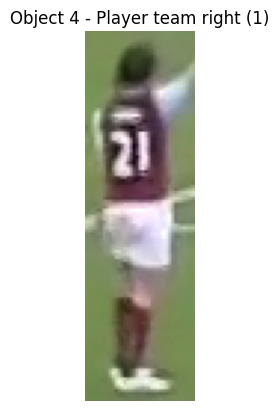

Predicted Jersey: 10
Confidence: 29.41 %

Detection 5
Class: Player team right (1)
BBox: (116, 737, 174, 873)


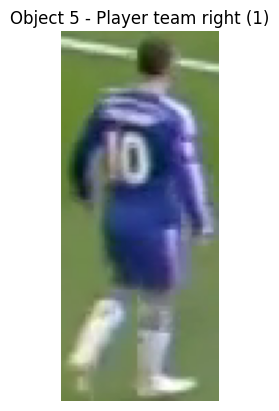

Predicted Jersey: 9
Confidence: 25.05 %

Detection 6
Class: Player team left (0)
BBox: (1361, 595, 1424, 721)


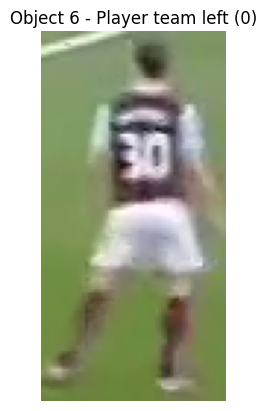

Predicted Jersey: 22
Confidence: 21.19 %

Detection 7
Class: Player team left (0)
BBox: (1208, 720, 1263, 875)


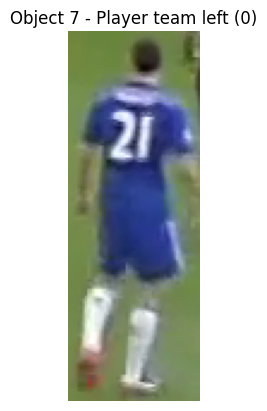

Predicted Jersey: 9
Confidence: 17.34 %

Detection 8
Class: Player team right (1)
BBox: (1361, 596, 1425, 720)


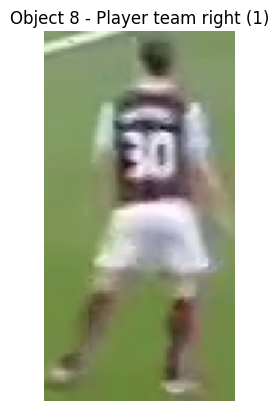

Predicted Jersey: 5
Confidence: 22.81 %

Detection 9
Class: Player team right (1)
BBox: (1062, 517, 1101, 620)


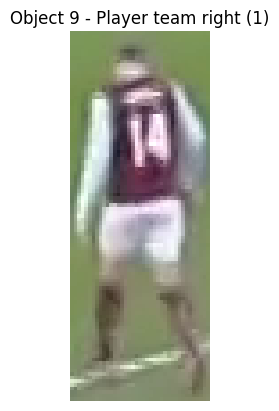

Predicted Jersey: 9
Confidence: 16.9 %

Detection 10
Class: Player team right (1)
BBox: (1501, 485, 1548, 586)


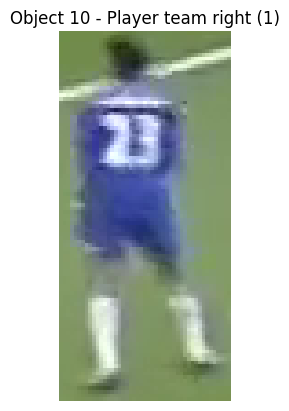

Predicted Jersey: 9
Confidence: 19.58 %

Detection 11
Class: Player team left (0)
BBox: (117, 737, 173, 873)


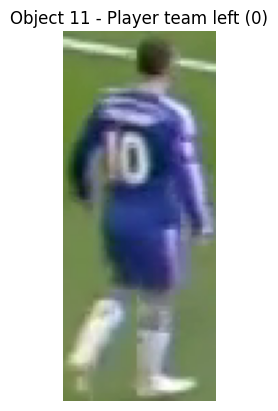

Predicted Jersey: 9
Confidence: 20.02 %

Detection 12
Class: Player team left (0)
BBox: (1062, 517, 1102, 620)


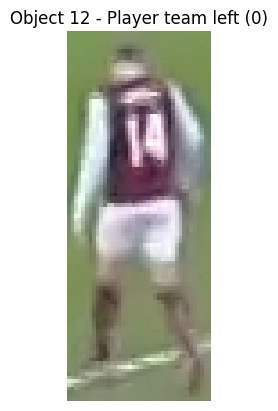

Predicted Jersey: 10
Confidence: 20.87 %

Detection 13
Class: Player team left (0)
BBox: (970, 574, 1005, 698)


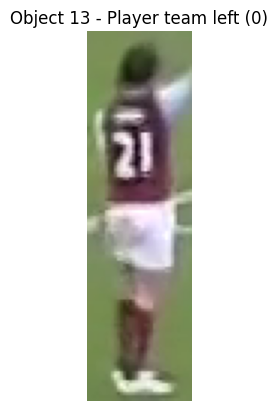

Predicted Jersey: 9
Confidence: 24.83 %

Detection 14
Class: Player team right (1)
BBox: (554, 591, 598, 705)


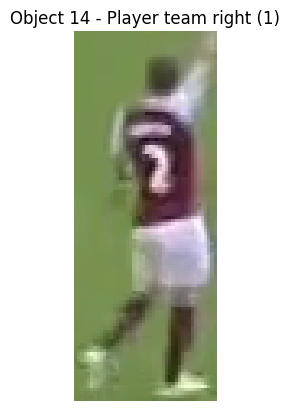

Predicted Jersey: 4
Confidence: 20.62 %

Detection 15
Class: Player team left (0)
BBox: (1502, 484, 1547, 586)


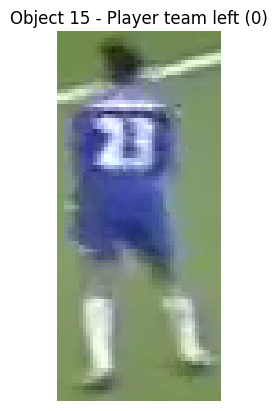

Predicted Jersey: 9
Confidence: 22.62 %

Detection 16
Class: Player team left (0)
BBox: (936, 436, 979, 531)


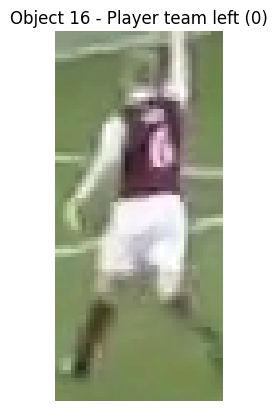

Predicted Jersey: 30
Confidence: 17.18 %

Detection 17
Class: Player team right (1)
BBox: (936, 435, 976, 530)


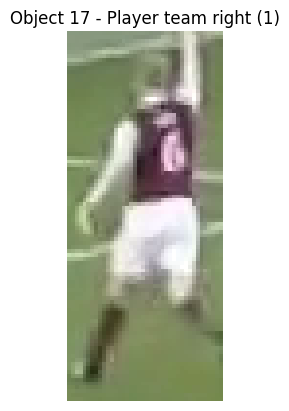

Predicted Jersey: 30
Confidence: 16.97 %

Detection 18
Class: Player team right (1)
BBox: (1186, 574, 1234, 707)


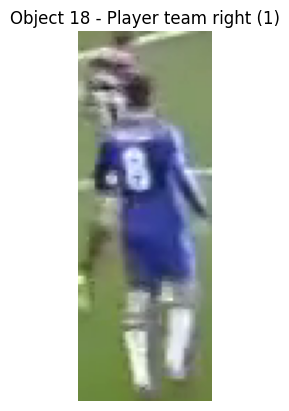

Predicted Jersey: 29
Confidence: 38.69 %

Detection 19
Class: Player team right (1)
BBox: (1283, 403, 1328, 495)


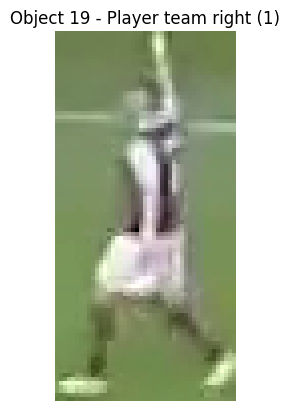

Predicted Jersey: 22
Confidence: 22.41 %

Detection 20
Class: Player team left (0)
BBox: (1253, 670, 1306, 806)


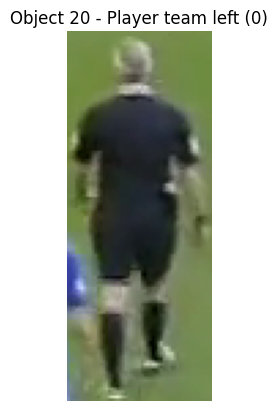

Predicted Jersey: 6
Confidence: 43.37 %

Detection 21
Class: Player team left (0)
BBox: (783, 535, 828, 638)


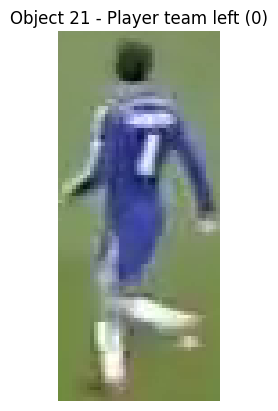

Predicted Jersey: 6
Confidence: 21.77 %

Detection 22
Class: Player team right (1)
BBox: (1208, 721, 1261, 875)


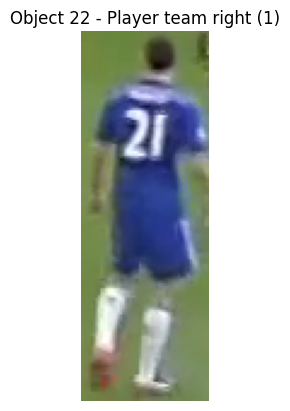

Predicted Jersey: 10
Confidence: 14.56 %

Detection 23
Class: Player team right (1)
BBox: (1593, 378, 1626, 470)


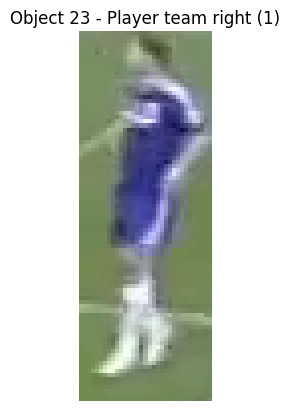

Predicted Jersey: 6
Confidence: 30.74 %

Detection 24
Class: Player team left (0)
BBox: (1187, 574, 1236, 706)


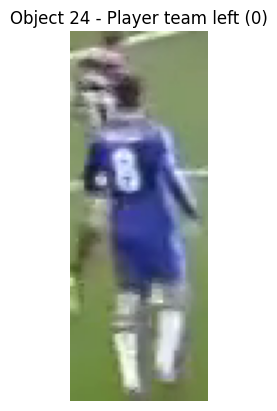

Predicted Jersey: 29
Confidence: 32.04 %

Detection 25
Class: Player team left (0)
BBox: (854, 488, 891, 589)


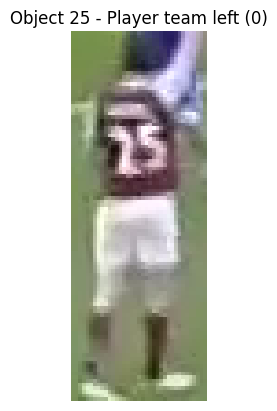

Predicted Jersey: 29
Confidence: 30.93 %

Detection 26
Class: Player team right (1)
BBox: (1253, 668, 1305, 804)


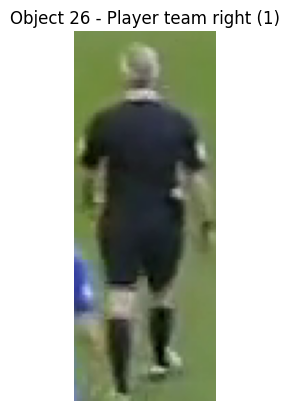

Predicted Jersey: 6
Confidence: 35.96 %

STEP 3: Final Output Image


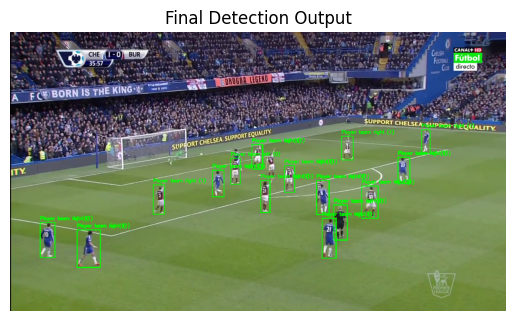


Saved: output_with_jersey.jpg


In [2]:
import cv2
import torch
import numpy as np
from PIL import Image
from ultralytics import YOLO
from torchvision import models
import torch.nn as nn
import json
from torchvision import models, transforms
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG
# -----------------------------
YOLO_MODEL_PATH = "runs/detect/train/weights/best.pt"
JERSEY_MODEL_PATH = "jersey_classifier.pth"
CONF_THRESHOLD = 0.0

# -----------------------------
# DEVICE SETUP
# -----------------------------
device = (
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)

print("Using Device:", device)

# -----------------------------
# IMAGE DISPLAY FUNCTION (Notebook Safe)
# -----------------------------
def show_image(image, title="Image"):
    plt.figure()
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

# -----------------------------
# LOAD YOLO MODEL
# -----------------------------
print("\nLoading YOLO model...")
yolo_model = YOLO(YOLO_MODEL_PATH)
print("Classes:", yolo_model.names)

# -----------------------------
# LOAD JERSEY MODEL
# -----------------------------
# Recreate label mapping EXACTLY like training
with open("Data/Jersey/train_gt.json") as f:
    gt = json.load(f)

gt = {k:int(v) for k,v in gt.items() if int(v) != -1}

unique_numbers = sorted(set(gt.values()))
label_map = {num:i for i,num in enumerate(unique_numbers)}

# Reverse mapping (index -> jersey number)
reverse_label_map = {v:k for k,v in label_map.items()}

num_classes = len(unique_numbers)

print("Total classes:", num_classes)

# Recreate JERSEY DETECTION Model Architecture EXACTLY like training
jersey_model = models.resnet18(weights=None)

# Freeze backbone (not mandatory for inference but safe)
for param in jersey_model.parameters():
    param.requires_grad = False

jersey_model.fc = nn.Linear(jersey_model.fc.in_features, num_classes)

jersey_model = jersey_model.to(device)

# Load JERSEY DETECTION MODEL
jersey_model.load_state_dict(torch.load("best_jersey_model.pth", map_location=device))

jersey_model.eval()

print("Best jersey model loaded successfully.")


# -----------------------------
# IMAGE TRANSFORM
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


# -----------------------------
# JERSEY PREDICTION
# -----------------------------
def predict_jersey_number(cropped_img):

    image = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = jersey_model(image)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)

    jersey_number = reverse_label_map[predicted_class.item()]
    return jersey_number, confidence.item()


# -----------------------------
# DETECT + DEBUG PIPELINE
# -----------------------------
def detect_and_debug(image_path):

    print("\nSTEP 1: Loading Image")
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found.")

    show_image(image, "Original Image")

    print("\nSTEP 2: Running YOLO Detection")
    results = yolo_model(image)[0]

    print("Total Detections:", len(results.boxes))

    output_image = image.copy()
    jersey_results = []

    for i, box in enumerate(results.boxes):

        cls_id = int(box.cls.item())
        class_name = yolo_model.names[cls_id]
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        print(f"\nDetection {i+1}")
        print("Class:", class_name)
        print("BBox:", (x1, y1, x2, y2))

        object_crop = image[y1:y2, x1:x2]

        if object_crop.size == 0:
            print("Empty crop, skipping")
            continue

        show_image(object_crop, f"Object {i+1} - {class_name}")

        label_text = class_name

        # -------------------------
        # PLAYER → Jersey Prediction
        # -------------------------
        if "player" in class_name.lower():

            jersey_number, jersey_conf = predict_jersey_number(object_crop)

            print("Predicted Jersey:", jersey_number)
            print("Confidence:", round(jersey_conf*100,2), "%")

        # Draw bounding box
        cv2.rectangle(output_image, (x1,y1),(x2,y2),(0,255,0),2)
        cv2.putText(output_image, label_text,
                    (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6,
                    (0,255,0),
                    2)

    print("\nSTEP 3: Final Output Image")
    show_image(output_image, "Final Detection Output")

    return output_image, jersey_results


# -----------------------------
# RUN
# -----------------------------
image_path = "Data/Soccernet_yolo/train/images/7.png"

output_image, results = detect_and_debug(image_path)

cv2.imwrite("output_with_jersey.jpg", output_image)
print("\nSaved: output_with_jersey.jpg")
